# 02_Data Cleaning and EDA

In [1]:
# load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

### Contents:
- [1.0 Data Import](#1.0-Data-Import-and-Cleaning)
- [2.0 Add target and combine data sets](#2.0-Add-target-and-combine-data-sets)
- [3.0 Explore the structure of Posts dataframs](#3.0-Explore-the-structure-of-Post-Dataframe)
    - [3.1 Check dataframe and dtypes](#3.1-Check-dataframe-and-dtypes)
    - [3.2 Check for missing values](#3.2-Check-for-missing-values)
    - [3.3 Summary Statistics Posts](#3.3-Summary-Statistics)
- [4.0 Explore the structure of Comments dataframe](#4.0-Explore-the-structure-of-Comments-Dataframe)
    - [4.1 Check dataframe and dtypes](#4.1-Check-dataframe-and-dtypes)
    - [4.2 Check for missing values](#4.2-Check-for-missing-values)
    - [4.3 Summary Statistics Posts](#4.3-Summary-Statistics)
- [5.0 Investigate word counts and post length](#5.0-Investigate-word-counts-and-post-length)
    - [5.1 Combine the posts and comments to analyse the text](#Combine-the-posts-and-comments-to-analyse-the-text)
    - [5.2 Investigate Outliers](#5.2-Investigate-Outliers)
    - [5.3 Author cross contamination check](#5.3-Author-cross-contamination-check)
    - [5.4 Investigate the frequecy of words](#5.4-Investigate-the-frequecy-of-words)
        - [5.4.2 Data Science Countvectorizer](#5.4.1-Data-Science-Countvectorizer)
        - [5.4.2 Analytics Countvectorizer](#5.4.2-Analytics-Countvectorizer)
- [6.0 Insights](#6.0-Insights)

# 1.0 Data Import and Cleaning

#### Get Data

In [2]:
ds_df = pd.read_csv('./data/datascience.csv', index_col = False)
analytics_df = pd.read_csv('./data/analytics.csv', index_col = False)
ds_comms_df = pd.read_csv('./data/ds_comments.csv', index_col = False)
analytics_comms_df = pd.read_csv('./data/analytics_comments.csv', index_col = False)

In [3]:
# Check the posts data is the same
ds_df.shape, analytics_df.shape

((629, 18), (679, 18))

In [4]:
# Check the comments data is the same
ds_comms_df.shape, analytics_comms_df.shape

((6951, 13), (2379, 13))

### Check column names are the same for both posts and comments

In [5]:
# check cols are the same for the post data

data_sc_df_cols = set(ds_df.columns)
analytics_df_cols = set(analytics_df.columns)
data_sc_df_cols - analytics_df_cols

set()

In [6]:
# check cols are the same for the comments data

data_sc_comms_cols = set(ds_comms_df.columns)
analytics__comms_cols = set(analytics_comms_df.columns)
data_sc_df_cols - analytics_df_cols

set()

---

# 2.0 Add target and combine data sets

### Update column names

In [7]:
ds_df.rename(columns={'subreddit_name_prefixed':'subreddit', 'link_flair_text':'category'}, inplace=True)
analytics_df.rename(columns={'subreddit_name_prefixed':'subreddit', 'link_flair_text':'category'}, inplace=True)

In [8]:
# check it worked
ds_df[['subreddit','category']].head()

,subreddit,category
0,r/datascience,Discussion
1,r/datascience,Education
2,r/datascience,Career
3,r/datascience,Education
4,r/datascience,Job Search


In [9]:
analytics_df[['subreddit','category']].head()

,subreddit,category
0,r/analytics,NaN
1,r/analytics,NaN
2,r/analytics,Question
3,r/analytics,NaN
4,r/analytics,NaN


In [10]:
# Function to remove the 'r/'
def remove_r(subreddit): 
    # Search for the pattern
    if re.search('^r\/', subreddit): 
        # If found get the end of the pattern position
        pos = re.search('^r\/', subreddit).end() 

        # return the cleaned name 
        return subreddit[pos:] 
    else: 
        # if pattern doesnt exist return unchanged
        return subreddit 

In [11]:
# Updated the columns 
ds_df['subreddit'] = ds_df['subreddit'].apply(remove_r) 
analytics_df['subreddit'] = analytics_df['subreddit'].apply(remove_r) 

In [12]:
ds_df[['subreddit']].head(2)

,subreddit
0,datascience
1,datascience


In [13]:
analytics_df[['subreddit']].head(2)

,subreddit
0,analytics
1,analytics


#### Add a tag to show its a Post not a Comment for when the data is combined

In [14]:
ds_df['subreddit'] = ds_df['subreddit'].apply(remove_r) 
analytics_df['subreddit'] = analytics_df['subreddit'].apply(remove_r) 

In [15]:
ds_df['type'] = 'post'
analytics_df['type'] = 'post'

In [16]:
ds_df[['subreddit','type']].head(2)

,subreddit,type
0,datascience,post
1,datascience,post


In [17]:
analytics_df[['subreddit','type']].head(2)

,subreddit,type
0,analytics,post
1,analytics,post


#### Add a tag to show its a Comment not a Post for when the data is combined

In [18]:
#### The comments dataframe already has a subreddit column which can used to ID the source

In [19]:
analytics_comms_df['subreddit'].head()

0    analytics
1    analytics
2    analytics
3    analytics
4    analytics
Name: subreddit, dtype: object

In [20]:
#### Therefore I'll just add type columns

In [21]:
ds_comms_df['type'] = 'comment'
analytics_comms_df['type'] = 'comment'

In [22]:
ds_comms_df[['subreddit','type']].head(2)

,subreddit,type
0,datascience,comment
1,datascience,comment


In [23]:
analytics_comms_df[['subreddit','type']].head(2)

,subreddit,type
0,analytics,comment
1,analytics,comment


---

## Append dataframes

+ I will append the posts dataframes together and the comments dataframes
+ This will enable me to deal with the cleaning and preprocessing more efficiently

In [24]:
posts_df = ds_df.append(analytics_df)
comments_df = ds_comms_df.append(analytics_comms_df)

In [25]:
posts_df.reset_index(drop=True, inplace=True)
comments_df.reset_index(drop=True, inplace=True)

In [26]:
# Shape adds up to original shape plus one more column which was added to both
posts_df.shape, comments_df.shape

((1308, 19), (9330, 14))

---

# 3.0 Explore the structure of Post Dataframe

#### This Dateframe contains the post data scrpaed from the 2 subreddits

---

## 3.1 Check dataframe and dtypes

##### Observations on posts dataframes
+ 'subreddit_name_prefixed' is useful to identify origin but will change it to 'subreddit'
+ 'link_flair_text' might be interesting to split the data up on
+ 'score' and 'upvote' might be a way to split data if necesary. Could determine whether a high score resonates more for people in the community. 
+ 'title' might be a useful source of extra data 

In [27]:
posts_df.iloc[:,0:9].head()

,subreddit,selftext,author_fullname,title,link_flair_css_class,name,upvote_ratio,ups,category
0,datascience,Welcome to this week's entering &amp; transiti...,t2_4l4cxw07,Weekly Entering &amp; Transitioning Thread | 2...,NaN,t3_hd5t6m,0.66,1,Discussion
1,datascience,NaN,t2_3rl9tafm,The best SQL vs NoSQL mindset I've ever heard,education,t3_hd3tqs,0.87,48,Education
2,datascience,"Hello all,\n\nI am a Data Scientist at a Fortu...",t2_1jwhofnt,Amazon AWS Pro-Serve Data Scientist is it a go...,career,t3_hcxeno,0.94,94,Career
3,datascience,"Hi,\n\nA friend of mine is doing MSCS and we a...",t2_3b84s1v5,Help with implementation of a paper about Imba...,education,t3_hd4xlb,0.75,4,Education
4,datascience,Planning a move from Toronto - I've heard sala...,t2_6ltcva0l,How are data science salaries in Montreal for ...,NaN,t3_hcyrod,0.83,17,Job Search


In [28]:
posts_df.iloc[:,9:].head()

,score,created,selftext_html,id,author,num_comments,permalink,url,created_utc,type
0,1,1.592770e+09,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",hd5t6m,datascience-bot,5,/r/datascience/comments/hd5t6m/weekly_entering...,https://www.reddit.com/r/datascience/comments/...,1.592741e+09,post
1,48,1.592759e+09,NaN,hd3tqs,kotartemiy,6,/r/datascience/comments/hd3tqs/the_best_sql_vs...,https://codarium.substack.com/p/the-best-sql-v...,1.592730e+09,post
2,94,1.592729e+09,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",hcxeno,GreenerCar,13,/r/datascience/comments/hcxeno/amazon_aws_pros...,https://www.reddit.com/r/datascience/comments/...,1.592700e+09,post
3,4,1.592765e+09,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",hd4xlb,takathur,0,/r/datascience/comments/hd4xlb/help_with_imple...,https://www.reddit.com/r/datascience/comments/...,1.592736e+09,post
4,17,1.592734e+09,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",hcyrod,remembr_this,11,/r/datascience/comments/hcyrod/how_are_data_sc...,https://www.reddit.com/r/datascience/comments/...,1.592706e+09,post


In [29]:
## Check datatypes
posts_df.dtypes

subreddit                object
selftext                 object
author_fullname          object
title                    object
link_flair_css_class     object
name                     object
upvote_ratio            float64
ups                       int64
category                 object
score                     int64
created                 float64
selftext_html            object
id                       object
author                   object
num_comments              int64
permalink                object
url                      object
created_utc             float64
type                     object
dtype: object

### Observation

+ Most of the data is text so there will be less distributions and statistics to look at
+ However there will be more 

---

## 3.2 Check for missing values
+ Are there any missing values and plan to deal with them appropriately?

In [30]:
# function to change the colour of nulls to maje it more noticeable
def highlight_nulls(cell):
    back_color = {True: "background-color: lightblue", False:""}
    is_null_col = (cell != 0 ).replace(back_color)
    return is_null_col

In [31]:
# get nulls from the dataframe
null = pd.DataFrame(posts_df.isnull().sum())
null.reset_index(inplace=True)

In [32]:
# rename columns
null.rename(columns={0:'null_count', 'index':'column'}, inplace=True)

In [33]:
null.style.apply(highlight_nulls,subset=['null_count'])

,column,null_count
0,subreddit,0
1,selftext,104
2,author_fullname,20
3,title,0
4,link_flair_css_class,703
5,name,0
6,upvote_ratio,0
7,ups,0
8,category,452
9,score,0


#### Example of column content

'selftext' and the 'selftext_html' 

+ These are crucial as that is where the words are going to come from. Therefore I have no choice but to drop these rows. This is accounts for almost 8% of the post data. However this is why I scraped the comments data to ensure there was enough text to use.

'category' 

+ This column I made to potentially see if different types of posts are more useful than others. However it is not critical. I could use the median or mode to add the category. Howeve this could bias the results. It would best be served as a seperate classficiation NLP challenge. Therefore i will just change the nulls to 'Unknown'

'link_flair_css_class' 

+ This has similar but less robust information than category. Therefore it actually isnt that useful so I will drop the column especially as it only almost 50% null columns

'author_fullname' 
+ There is only a small amount of data missing - 1.5%. It is also not so useful. I included it so I can check if the content is coming from a small number of authors or many. Also useful to see if authors were posting in both subreddits. So I will change the name to 'anonymous'

In [34]:
# Implement decisions from above

# drop missing selftext
posts_df.drop(posts_df.loc[posts_df['selftext'].isnull()].index, axis=0, inplace=True)

In [35]:
# rename missing authors to anonymous
posts_df.loc[posts_df['category'].isnull(),'category'] = 'Unknown'

In [36]:
# drop 'link_flair_css_class' column
posts_df.drop(columns='link_flair_css_class', inplace=True);

In [37]:
# rename missing authors to anonymous
posts_df.loc[posts_df['author_fullname'].isnull(), 'author_fullname'] = 'anonymous'

In [38]:
# recheck nulls
null = pd.DataFrame(posts_df.isnull().sum())
null.reset_index(inplace=True)
null.rename(columns={0:'null_count', 'index':'column'}, inplace=True)

In [39]:
null.style.apply(highlight_nulls,subset=['null_count'])

,column,null_count
0,subreddit,0
1,selftext,0
2,author_fullname,0
3,title,0
4,name,0
5,upvote_ratio,0
6,ups,0
7,category,0
8,score,0
9,created,0


### observation
+ nulls have been reviewed and processed

---

## 3.3 Summary Statistics

In [40]:
posts_df.loc[posts_df['subreddit']=='datascience'].describe()

,upvote_ratio,ups,score,created,num_comments,created_utc
count,561.000000,561.000000,561.000000,5.610000e+02,561.000000,5.610000e+02
mean,0.791604,64.003565,64.003565,1.588642e+09,29.172906,1.588613e+09
std,0.199587,151.296516,151.296516,2.711082e+06,48.091769,2.711082e+06
min,0.200000,0.000000,0.000000,1.584613e+09,0.000000,1.584584e+09
25%,0.670000,1.000000,1.000000,1.585687e+09,4.000000,1.585658e+09
50%,0.860000,5.000000,5.000000,1.588897e+09,10.000000,1.588868e+09
75%,0.960000,31.000000,31.000000,1.591180e+09,27.000000,1.591151e+09
max,1.000000,1432.000000,1432.000000,1.592779e+09,369.000000,1.592750e+09


In [41]:
posts_df.loc[posts_df['subreddit']=='analytics'].describe()

,upvote_ratio,ups,score,created,num_comments,created_utc
count,643.000000,643.000000,643.000000,6.430000e+02,643.000000,6.430000e+02
mean,0.898787,7.667185,7.667185,1.586039e+09,8.066874,1.586010e+09
std,0.158272,10.258100,10.258100,4.298064e+06,9.245536,4.298064e+06
min,0.140000,0.000000,0.000000,1.578600e+09,0.000000,1.578571e+09
25%,0.850000,1.000000,1.000000,1.582078e+09,2.000000,1.582049e+09
50%,1.000000,3.000000,3.000000,1.586480e+09,5.000000,1.586451e+09
75%,1.000000,10.000000,10.000000,1.589871e+09,11.000000,1.589842e+09
max,1.000000,72.000000,72.000000,1.592741e+09,79.000000,1.592712e+09


### How many points above the 75% mark?

In [42]:
# Data Science number of num_comments and score outliers
posts_df.loc[(posts_df['num_comments'] > 31) & (posts_df['subreddit'] == 'datascience'),'score'].size

123

In [43]:
posts_df.loc[(posts_df['score'] > 31) & (posts_df['subreddit'] == 'datascience'),'score'].size

137

In [44]:
# Data Science num_comments and score outliers
posts_df.loc[(posts_df['num_comments'] > 10) & (posts_df['subreddit'] == 'analytics'),'score'].size

173

In [45]:
posts_df.loc[(posts_df['score'] > 10) & (posts_df['subreddit'] == 'analytics'),'score'].size

149

## Observations
+ A minus score is possible for unpopular posts but likely to be removed soon by reddit moderators meaning the outliers are more extreme on the positive side. 


+ The large scores and comments shows that some posts resonate more than others. This is obvious but it may indicate that these post are a better indicators of the language as it has galvanised the community. I may look into this further later to see if its a true.


+ The difference between the scores magnitude is likely due to the amount of subscribers. However it may be possible to use that to scale if I need to investigate further.


#### NB it is clear that score and ups are the same so i will drop ups ans score is a better description of how its calulated

In [46]:
# drop 'ups' column
posts_df.drop(columns='ups', inplace=True)

---

## A closer look at some of the distributions

---

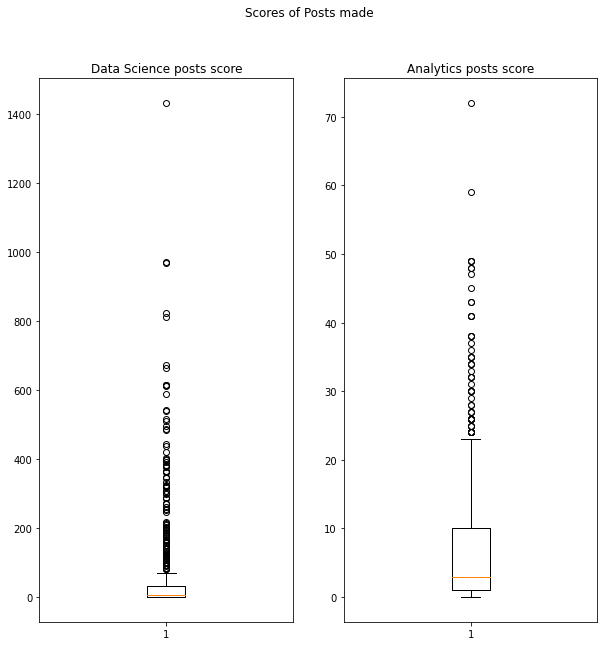

In [47]:
# Plot the Scores distribution

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.suptitle('Scores of Posts made')
ax1.boxplot(posts_df['score'].loc[posts_df['subreddit']=='datascience'])
ax2.boxplot(posts_df['score'].loc[posts_df['subreddit']=='analytics'])
ax1.set_title('Data Science posts score')
ax2.set_title('Analytics posts score');


### Observations

+ The Distributions are on different scales but are actually quite similar. 

+ The gap between the 25% and 75% is 30 for data science

+ The gap between the 25% and 75% is 9 for analytics


+ The difference is about 3 times, however the number of members of each subreddit are as follows
    + Datascience = 239,000
    + Analytics = 63,000
    
    
+ It is unknown how mnay active members there are. however a rough estimate suggests that actually I would expect to see 4 times the difference. So maybe analytics mebers are disproportiantely more engaged then the data sceince members

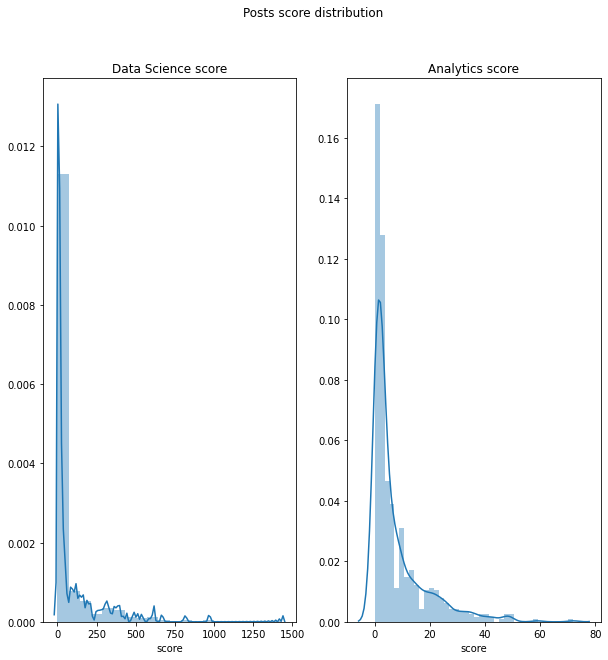

In [48]:
# plot histogram for score distribution
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
fig.suptitle('Posts score distribution')

sns.distplot(posts_df['score'].loc[posts_df['subreddit']=='datascience'], bins=20, ax=ax1)
sns.distplot(posts_df['score'].loc[posts_df['subreddit']=='analytics'], bins=40, ax=ax2)
ax1.set_title('Data Science score')
ax2.set_title('Analytics score');

### Observations on the Histograms. 

+ The distribution shape for both scores is similar
+ The distribution is not normal it looks like a poisson distribution
+ They has a positive skew


This is probably because its more likely because if a score is to low and rececive a lot of down votes then it will be removed thus it would be missing from my data and preventing a normal distribution.

---

# 4.0 Explore the structure of Comments Dataframe

#### This Dateframe contains the post data scrpaed from the 2 subreddits

---

## 4.1 Check dataframe and dtypes

In [49]:
comments_df.iloc[:,0:7].head()

,ups,id,author,score,author_fullname,body,body_html
0,1.0,fvjpubi,ToothPickLegs,1.0,t2_55fytx,Good degree setup for Data Science career?\n\n...,"&lt;div class=""md""&gt;&lt;p&gt;Good degree set..."
1,1.0,fvjj6gv,sl5567,1.0,t2_674p23vi,I'm located in the NYC area and currently loo...,"&lt;div class=""md""&gt;&lt;p&gt;I&amp;#39;m loc..."
2,3.0,fvj6yfx,Kamiklo,3.0,t2_4ygyz290,What kind of open source projects can I contri...,"&lt;div class=""md""&gt;&lt;p&gt;What kind of op..."
3,1.0,fvj6rzt,productive_guy123,1.0,t2_2a4d4wz8,I am coming from a finance (BA) background and...,"&lt;div class=""md""&gt;&lt;p&gt;I am coming fro..."
4,1.0,fvj5rh5,YoYoVaTsA,1.0,t2_zacn2,"So, I have studied the math and stats and mach...","&lt;div class=""md""&gt;&lt;p&gt;So, I have stud..."


In [50]:
comments_df.iloc[:,7:].head()

,permalink,name,created,created_utc,subreddit,link_id,type
0,/r/datascience/comments/hd5t6m/weekly_entering...,t1_fvjpubi,1.592784e+09,1.592755e+09,datascience,t3_hd5t6m,comment
1,/r/datascience/comments/hd5t6m/weekly_entering...,t1_fvjj6gv,1.592780e+09,1.592751e+09,datascience,t3_hd5t6m,comment
2,/r/datascience/comments/hd5t6m/weekly_entering...,t1_fvj6yfx,1.592771e+09,1.592743e+09,datascience,t3_hd5t6m,comment
3,/r/datascience/comments/hd5t6m/weekly_entering...,t1_fvj6rzt,1.592771e+09,1.592742e+09,datascience,t3_hd5t6m,comment
4,/r/datascience/comments/hd5t6m/weekly_entering...,t1_fvj5rh5,1.592770e+09,1.592741e+09,datascience,t3_hd5t6m,comment


### Check datatypes

In [51]:
comments_df.dtypes

ups                float64
id                  object
author              object
score              float64
author_fullname     object
body                object
body_html           object
permalink           object
name                object
created            float64
created_utc        float64
subreddit           object
link_id             object
type                object
dtype: object

### Observation

+ Most of the data is text so there will be less distributions and statistics to look at
+ However there will be more 

---

## 4.2 Check for missing values
Are there any missing values and if so decide what to do with them

In [52]:
# get nulls 
null_a = pd.DataFrame(comments_df.isnull().sum())
null_a.reset_index(inplace=True)

In [53]:
# rename columns
null_a.rename(columns={0:'null_count', 'index':'column'}, inplace=True)

In [54]:
# show nulls
null_a.style.apply(highlight_nulls, subset=['null_count'])

,column,null_count
0,ups,9
1,id,0
2,author,9
3,score,9
4,author_fullname,414
5,body,9
6,body_html,9
7,permalink,9
8,name,0
9,created,9


#### Example of column content

+ I will check to see if the 9's are all the same rows


+ Just like the 'Posts' data, the 'author_fullname' has only a small amount of data missing. It is also not so useful. I included it so I can check if the content is coming from a small nuber of authors or many. Also useful to see if authore were posting in both subreddits. So I will change the name to 'anonymous'

In [55]:
# implement decisions from above

# rename missing authors to anonymous
comments_df.loc[comments_df['author_fullname'].isnull(),'author_fullname'] = 'anonymous'

In [56]:
comments_df.loc[comments_df['ups'].isnull(),]

,ups,id,author,score,author_fullname,body,body_html,permalink,name,created,created_utc,subreddit,link_id,type
383,NaN,fv4qeus,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fv4qeus,NaN,NaN,NaN,NaN,comment
738,NaN,fulyqjp,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fulyqjp,NaN,NaN,NaN,NaN,comment
1898,NaN,fs6hoxv,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fs6hoxv,NaN,NaN,NaN,NaN,comment
3291,NaN,fq8yf5s,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fq8yf5s,NaN,NaN,NaN,NaN,comment
3411,NaN,fpvn5dt,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fpvn5dt,NaN,NaN,NaN,NaN,comment
3870,NaN,fphs336,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fphs336,NaN,NaN,NaN,NaN,comment
4440,NaN,fog1z3m,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fog1z3m,NaN,NaN,NaN,NaN,comment
4732,NaN,fnvlpt4,NaN,NaN,anonymous,NaN,NaN,NaN,t1_fnvlpt4,NaN,NaN,NaN,NaN,comment
6233,NaN,flqz56l,NaN,NaN,anonymous,NaN,NaN,NaN,t1_flqz56l,NaN,NaN,NaN,NaN,comment


In [57]:
# They are all the same so I will remove these rows. It accounts for less tha 0.1% of the data.

# drop missing rows
comments_df.drop(comments_df.loc[comments_df['ups'].isnull(),].index, axis=0, inplace=True)

In [58]:
# Check to see if there are any nulls

null_a = pd.DataFrame(comments_df.isnull().sum())
null_a.reset_index(inplace=True)
null_a.rename(columns={0:'null_count', 'index':'column'}, inplace=True)
null_a.style.apply(highlight_nulls, subset=['null_count'])

,column,null_count
0,ups,0
1,id,0
2,author,0
3,score,0
4,author_fullname,0
5,body,0
6,body_html,0
7,permalink,0
8,name,0
9,created,0


### observation
+ nulls have been reviewed and processed

---

## 4.3 Summary Statistics

In [59]:
# Check datascience subreddit

comments_df.loc[comments_df['subreddit']=='datascience'].describe()

,ups,score,created,created_utc
count,6942.000000,6942.000000,6.942000e+03,6.942000e+03
mean,10.055460,10.055460,1.588856e+09,1.588828e+09
std,38.765319,38.765319,2.411817e+06,2.411817e+06
min,-73.000000,-73.000000,1.584572e+09,1.584544e+09
25%,1.000000,1.000000,1.586688e+09,1.586660e+09
50%,2.000000,2.000000,1.588955e+09,1.588926e+09
75%,5.000000,5.000000,1.590967e+09,1.590939e+09
max,1363.000000,1363.000000,1.592784e+09,1.592755e+09


In [60]:
# check analytics subreddit

comments_df.loc[comments_df['subreddit']=='analytics'].describe()

,ups,score,created,created_utc
count,2379.000000,2379.000000,2.379000e+03,2.379000e+03
mean,3.772594,3.772594,1.586507e+09,1.586479e+09
std,5.989617,5.989617,4.267305e+06,4.267305e+06
min,-12.000000,-12.000000,1.578608e+09,1.578579e+09
25%,1.000000,1.000000,1.582494e+09,1.582465e+09
50%,2.000000,2.000000,1.587089e+09,1.587061e+09
75%,4.000000,4.000000,1.590322e+09,1.590293e+09
max,103.000000,103.000000,1.592785e+09,1.592757e+09


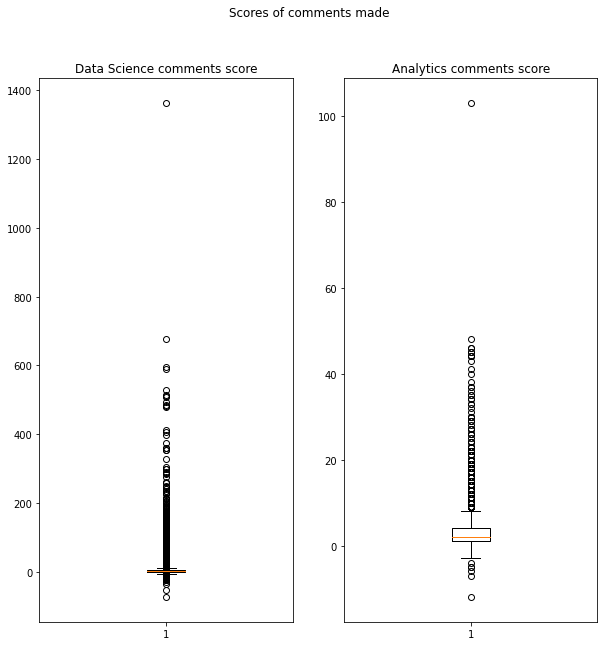

In [61]:
# plot a boxplot of the 

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.suptitle('Scores of comments made')
ax1.boxplot(comments_df['score'].loc[comments_df['subreddit']=='datascience'])
ax2.boxplot(comments_df['score'].loc[comments_df['subreddit']=='analytics'])
ax1.set_title('Data Science comments score')
ax2.set_title('Analytics comments score');


## Observations
+ The Distributions are on different scales but are actually quite similar. 


+ The gap between the 25% and 75% is 78 for data science
+ The gap between the 25% and 75% is 16 for analytics
+ Similar reasons to the Post boxplots

    
+ Interestingly there are more negative values, it is likely that they arent as well moderated like the posts.

#### NB it is clear that score and ups are the same so i will drop ups ans score is a better description of how its calulated

In [62]:
# drop 'ups' column
comments_df.drop(columns='ups', inplace=True);

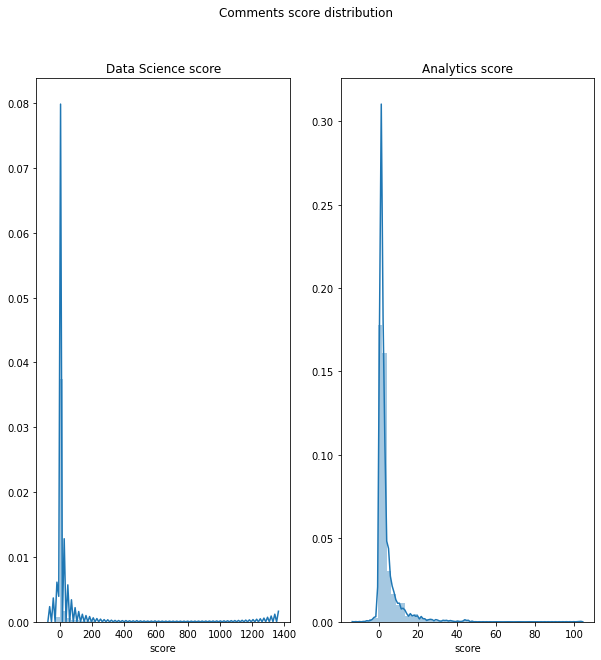

In [63]:
# plot histogram for score distribution

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
fig.suptitle('Comments score distribution')

sns.distplot(comments_df['score'].loc[comments_df['subreddit']=='datascience'], bins=60, ax=ax1)
sns.distplot(comments_df['score'].loc[comments_df['subreddit']=='analytics'], ax=ax2)
ax1.set_title('Data Science score')
ax2.set_title('Analytics score');

### Observations on the Histograms. 

+ The distribution shape for both scores is similar
+ The distribution is not normal it looks like a poisson distribution
+ It has a positive skew


This is probably because its more likely because if a score is to low and rececive a lot of down votes then it will be removed thus it would be missing from my data and preventing a normal distribution.

---

# 5.0 Investigate word counts and post length

## 5.1 Combine the posts and comments to analyse the text

In [64]:
# create a new dataframe with important columns from posts df
df_p = posts_df[['id','selftext','subreddit','type', 'permalink','author']]

In [65]:
df_p.shape

(1204, 6)

In [66]:
# create a new dataframe with important columns from comments df

df_c = pd.DataFrame(comments_df[['body', 'subreddit','type','author']])
df_c.shape

(9321, 4)

In [67]:
# add missing columns from comments dataframe
df_c['permalink'] = "Missing"
df_c['id'] = "Missing"

In [68]:
# remane to enable tables to join
df_p = df_p.rename(columns={'selftext':'body'})

In [69]:
# Join together
all_df = df_p.append(df_c)

In [70]:
# check it worked
all_df.shape

(10525, 6)

In [71]:
# drop the index
all_df.reset_index(drop=True, inplace=True)
all_df.shape

(10525, 6)

### Create a column with the number of words in it

In [72]:
all_df['len'] =[len(re.findall(r'\w+', x)) for x in all_df['body'].tolist()]
all_df.shape

(10525, 7)

In [73]:
# describe the datacience length of post
all_df['len'].loc[all_df['subreddit']=='datascience'].describe()

count    7503.000000
mean       84.311342
std       108.202494
min         0.000000
25%        20.000000
50%        51.000000
75%       108.500000
max      2164.000000
Name: len, dtype: float64

In [74]:
# describe the datacience length of post
all_df['len'].loc[all_df['subreddit']=='analytics'].describe()

count    3022.000000
mean       79.176042
std       110.868970
min         0.000000
25%        23.250000
50%        51.000000
75%       100.000000
max      3068.000000
Name: len, dtype: float64

### Observations

+ Data Science post are on average 5 words longer than 

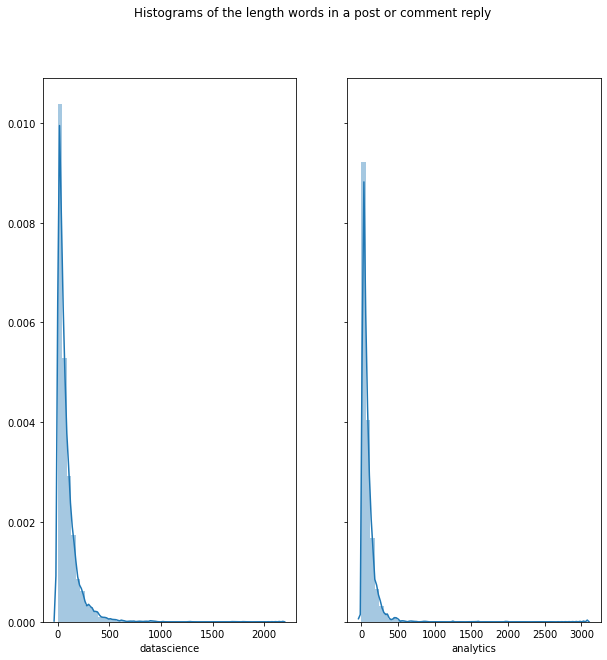

In [75]:
# create histogram of the words length

fig,(ax1, ax2) = plt.subplots(1,2, figsize=(10,10), sharey=True)
fig.suptitle('Histograms of the length words in a post or comment reply')
sns.distplot(all_df['len'].loc[all_df['subreddit']=='datascience'], ax=ax1)
sns.distplot(all_df['len'].loc[all_df['subreddit']=='analytics'], ax=ax2);

# name columns
ax1.set_xlabel('datascience')
ax2.set_xlabel('analytics');

### Observations

+ Distribution of both is similar
+ positive skew 
+ similar to poission distribution

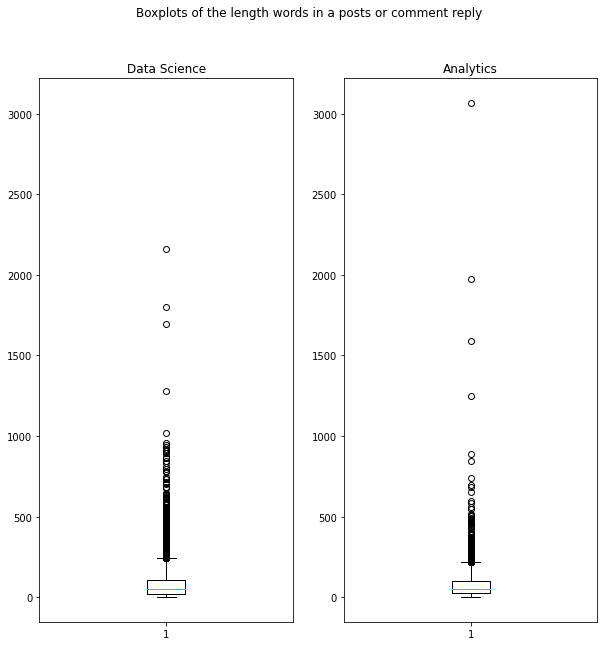

In [76]:
# Create a boxplot to show distribution and outliers for data science and analytics length of posts

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, sharey=ax1)
fig.suptitle('Boxplots of the length words in a posts or comment reply')
ax1.boxplot(all_df['len'].loc[all_df['subreddit']=='datascience'])
ax2.boxplot(all_df['len'].loc[all_df['subreddit']=='analytics'])
ax1.set_title('Data Science')
ax2.set_title('Analytics');

## 5.2 Investigate Outliers

In [77]:
# Find long posts
all_df.loc[all_df['len'] > 2000]

,id,body,subreddit,type,permalink,author,len
368,fzweaf,First - [I also published this on Medium if yo...,datascience,post,/r/datascience/comments/fzweaf/my_giant_data_q...,TB_R,2164
580,hbeoyt,"Forecasting the dynamics of revenue, audience,...",analytics,post,/r/analytics/comments/hbeoyt/how_to_forecast_k...,unab0mber,3068


In [78]:
all_df.iloc[368,4]

'/r/datascience/comments/fzweaf/my_giant_data_quality_checklist/'

In [79]:
all_df.iloc[580,4]

'/r/analytics/comments/hbeoyt/how_to_forecast_key_product_metrics_through/'

# Outliers

Whilst these are outliers they are genuine posts and therfore I will leave them in.

I checked the original data points:

+ [my_giant_data_quality_checklist](https://www.reddit.com/r/datascience/comments/fzweaf/my_giant_data_quality_checklist/)


+ [how_to_forecast_key_product_metrics_through](https://www.reddit.com/r/analytics/comments/hbeoyt/how_to_forecast_key_product_metrics_through/)


---

## 5.3 Author cross contamination check

I want to check that the posts in the subreddits are being written by the different people. A high number would mean that my data would be potentially diluted. They may have to be removed as the workds they use maybe specific to them and not the reddit.

In [80]:
# Get list of authors from the datascience reddit
authors_ds = list(all_df.loc[all_df['subreddit'] == 'datascience']['author'])

In [81]:
# Get list of authors from the analytics reddit
authors_analytics = list(all_df.loc[all_df['subreddit'] == 'analytics']['author'])

In [82]:
# Loop through both lists and get authors and their number of times they have posted in the both reddits
contributors = {}
for author in authors_analytics:
    for author2 in authors_ds:
        if author == author2:
            contributors[author] = contributors.get('author',0) + 1

# print the highest number of duplicated posters            
print(f"Highest number of duplicate post {contributors[max(contributors, key=lambda key: contributors[key])]}")
print(f"Total number of posts from members in both reddits: {sum(contributors.values())}")
print(f"Number of dual memberships {len(contributors.keys())}")

Highest number of duplicate post 1
Total number of posts from members in both reddits: 199
Number of dual memberships 199


## Observation

+ There is some overlap but its very insignificant so I can proceed without adjustments. 
+ It is good to know that there is only 199 active dual members so the data isnt compromised by bias.

---

## 5.4 Investigate the frequecy of words 

I will look to see if there are words which appear frequently in the two subreddits. 

+ I will use countvectoriser to get the words


+ Then compare the top 10 to see if there are any similarities or differences


+ I will check the n_grams for 1,1, 1,2 1,3 
    + This is because these fields often have a lot of terms and tools like data science
    + I dont want to miss these key terms

### 5.4.1 Data Science Countvectorizer

In [83]:
# split by reddit
ds_body = all_df.loc[all_df['subreddit'] == 'datascience', 'body']
analytics_body = all_df.loc[all_df['subreddit'] == 'analytics', 'body']

In [84]:
# get word counter for Data science

In [85]:
# Instantiate a CountVectorizer
cvec1 = CountVectorizer(stop_words='english')

In [86]:
# Fit the vectorizer on our text
cvec1.fit(ds_body)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [87]:
# Transform the corpus into a sparse matrix
X_train = cvec1.transform(ds_body)
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [88]:
# Convert X_train into a DataFrame
ds_words = pd.DataFrame(X_train.toarray(),
                   columns=cvec1.get_feature_names())

In [89]:
ds_words.shape

(7503, 18637)

In [90]:
# Show the top 15 analytic words for n_gram (1,1)

top_ds_df = pd.DataFrame(ds_words.sum())
top_ds_df.reset_index(inplace=True)
top_ds_df.rename(columns={0:'count', 'index':'word'}, inplace=True)
top_ds_1 = top_ds_df.sort_values(by='count', ascending=False).head(10)

In [91]:
top_ds_1

,word,count
4635,data,7768
14804,science,2828
9986,like,2275
18406,work,2211
9495,just,1958
16877,time,1752
5525,don,1606
9390,job,1581
12308,people,1534
9639,know,1446


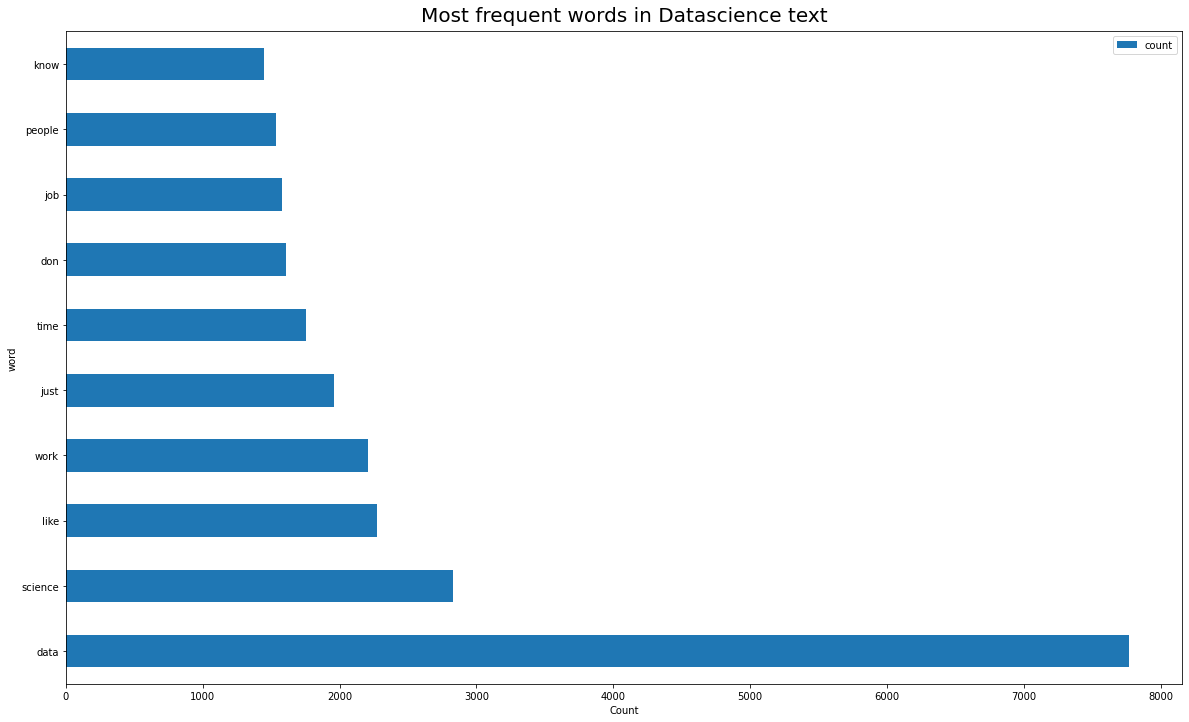

In [92]:
# plot bar graph of top word frequencies

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot()
top_ds_1.plot(x="word",y='count', kind='barh', ax=ax)
ax.set_title("Most frequent words in Datascience text", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("Count");

# observation

+ data, science, like, work are the most frequent indivisual words 

---

### 5.4.2 Analytics Countvectorizer

In [93]:
# Instantiate a CountVectorizer
cvec2 = CountVectorizer(stop_words='english')

In [94]:
# Fit the vectorizer on our text
cvec2.fit(analytics_body)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [95]:
# Transform the corpus into a sparse matrix
X_train = cvec2.transform(analytics_body)
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [96]:
# Convert X_train into a DataFrame
analytics_words = pd.DataFrame(X_train.toarray(),
                   columns=cvec2.get_feature_names())

In [97]:
# check rows still correct
analytics_words.shape

(3022, 10075)

In [98]:
# Show the top 15 analytic words

top_an_df = pd.DataFrame(analytics_words.sum())
top_an_df.reset_index(inplace=True)
top_an_df.rename(columns={0:'count', 'index':'word'}, inplace=True)
top_an_1 = top_an_df.sort_values(by='count', ascending=False).head(10)
top_an_1

,word,count
2435,data,2300
721,analytics,1404
5291,like,803
9948,work,691
5047,just,663
4105,google,653
9127,time,600
9771,want,577
9553,use,576
1450,business,566


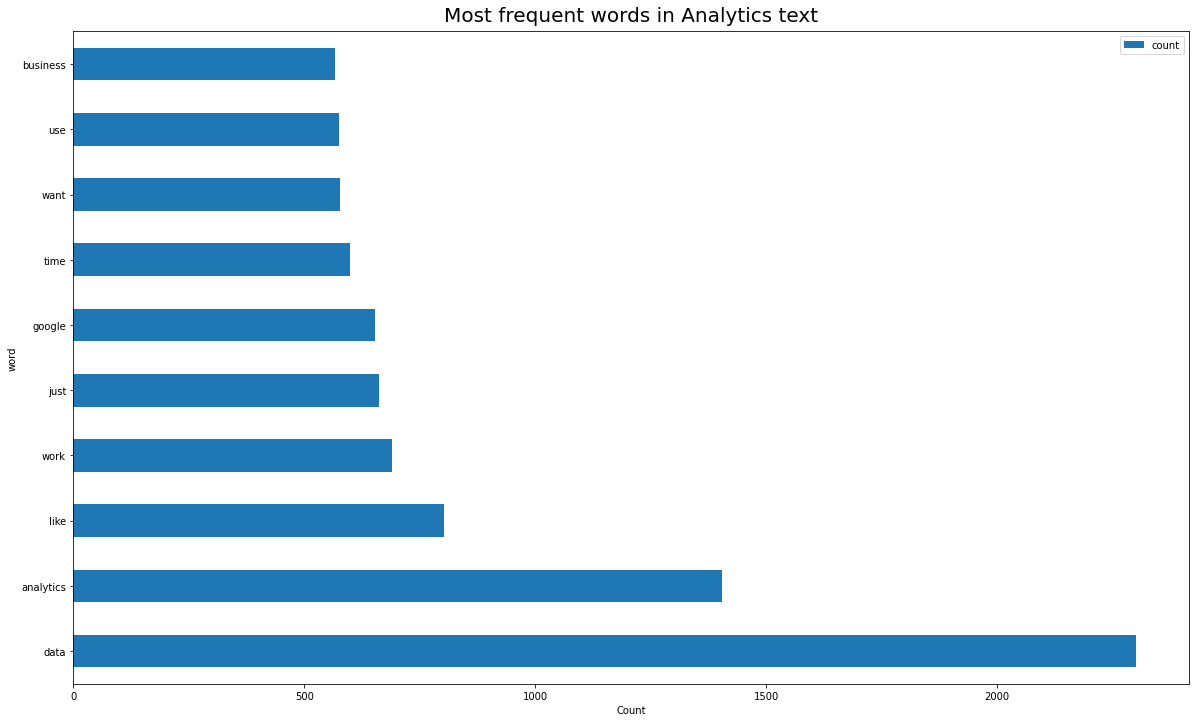

In [99]:
# plot bar graph of top word frequencies

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot()
top_an_1.plot(x="word",y='count', kind='barh', ax=ax)
ax.set_title("Most frequent words in Analytics text", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("Count");

### observation

+ data, analytics, like, work are the most frequent indivisual words 

---

### Repeat to allow 2-3 words patterns

In [100]:
# Instantiate a CountVectorizer
cvec3 = CountVectorizer(stop_words='english', ngram_range=(2,3))

In [101]:
# Fit the vectorizer on our text
cvec3.fit(ds_body)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 3), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [102]:
# Transform the corpus into a sparse matrix
X_train = cvec3.transform(ds_body)
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [103]:
# Convert X_train into a DataFrame
ds_words = pd.DataFrame(X_train.toarray(),
                   columns=cvec3.get_feature_names())

In [104]:
ds_words.shape

(7503, 460371)

In [105]:
# Show the top 15 analytic words for n_gram (1,1)

top_ds_df = pd.DataFrame(ds_words.sum())
top_ds_df.reset_index(inplace=True)
top_ds_df.rename(columns={0:'count', 'index':'word'}, inplace=True)
top_ds_1 = top_ds_df.sort_values(by='count', ascending=False).head(10)

In [106]:
top_ds_1

,word,count
92481,data science,2469
93427,data scientist,845
183987,https www,502
238841,machine learning,481
93863,data scientists,441
89187,data analyst,258
16671,amp x200b,254
115969,don know,252
89052,data analysis,177
90406,data engineering,156


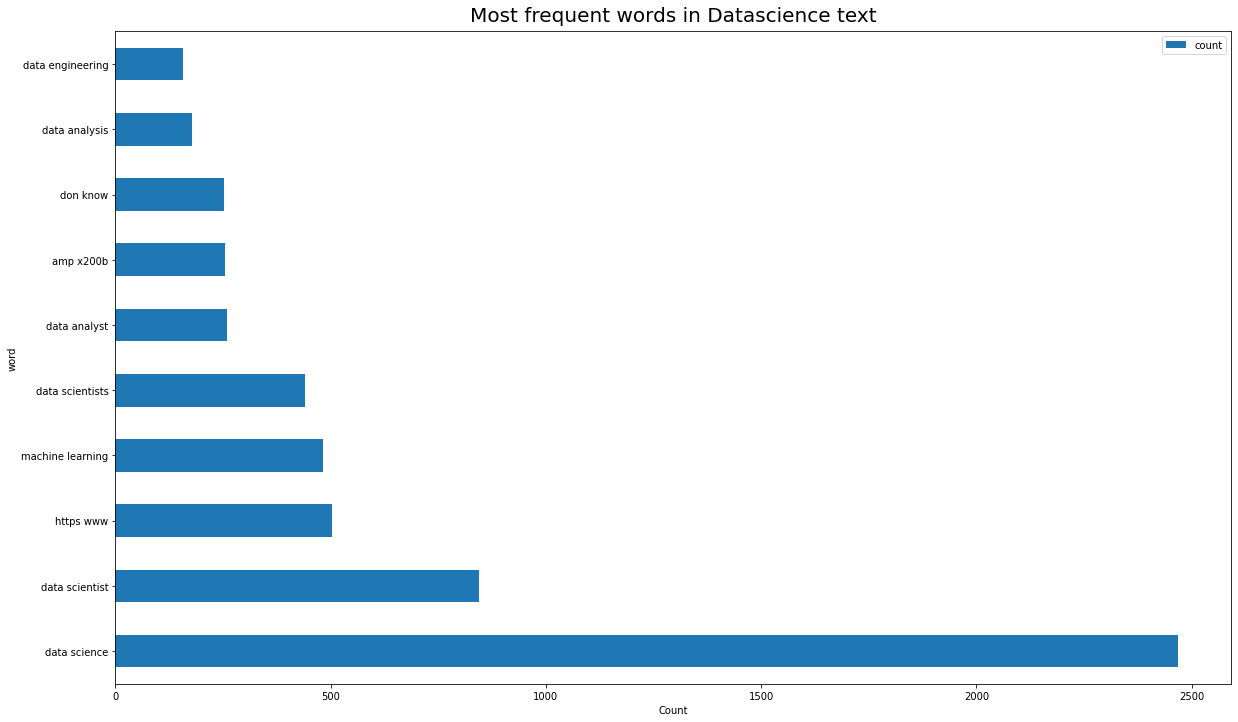

In [107]:
# plot bar graph of top word frequencies

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot()
top_ds_1.plot(x="word",y='count', kind='barh', ax=ax)
ax.set_title("Most frequent words in Datascience text", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("Count");

### Observations

+ This is much more informative the single words


+ Key themes and topics that are being discussed can clearly be seen to be forming
    + machine learning, don know, data engineering
    + data analysis does appear

---

### Repeat for Analytics

In [108]:
# Instantiate a CountVectorizer
cvec4 = CountVectorizer(stop_words='english', ngram_range=(2,3))

In [109]:
# Fit the vectorizer on our text
cvec4.fit(analytics_body)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(2, 3), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [110]:
# Transform the corpus into a sparse matrix
X_train = cvec4.transform(analytics_body)
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


In [111]:
# Convert X_train into a DataFrame
analytics_words = pd.DataFrame(X_train.toarray(),
                   columns=cvec4.get_feature_names())

In [112]:
# check rows still correct
analytics_words.shape

(3022, 183117)

In [113]:
# Show the top 15 analytic words

top_an_df = pd.DataFrame(analytics_words.sum())
top_an_df.reset_index(inplace=True)
top_an_df.rename(columns={0:'count', 'index':'word'}, inplace=True)
top_an_3 = top_an_df.sort_values(by='count', ascending=False).head(10)
top_an_3

,word,count
68522,google analytics,226
38704,data analyst,163
40498,data science,152
7569,amp x200b,126
119730,power bi,113
38834,data analytics,112
21963,business analytics,81
40927,data studio,77
68729,google com,74
38633,data analysis,74


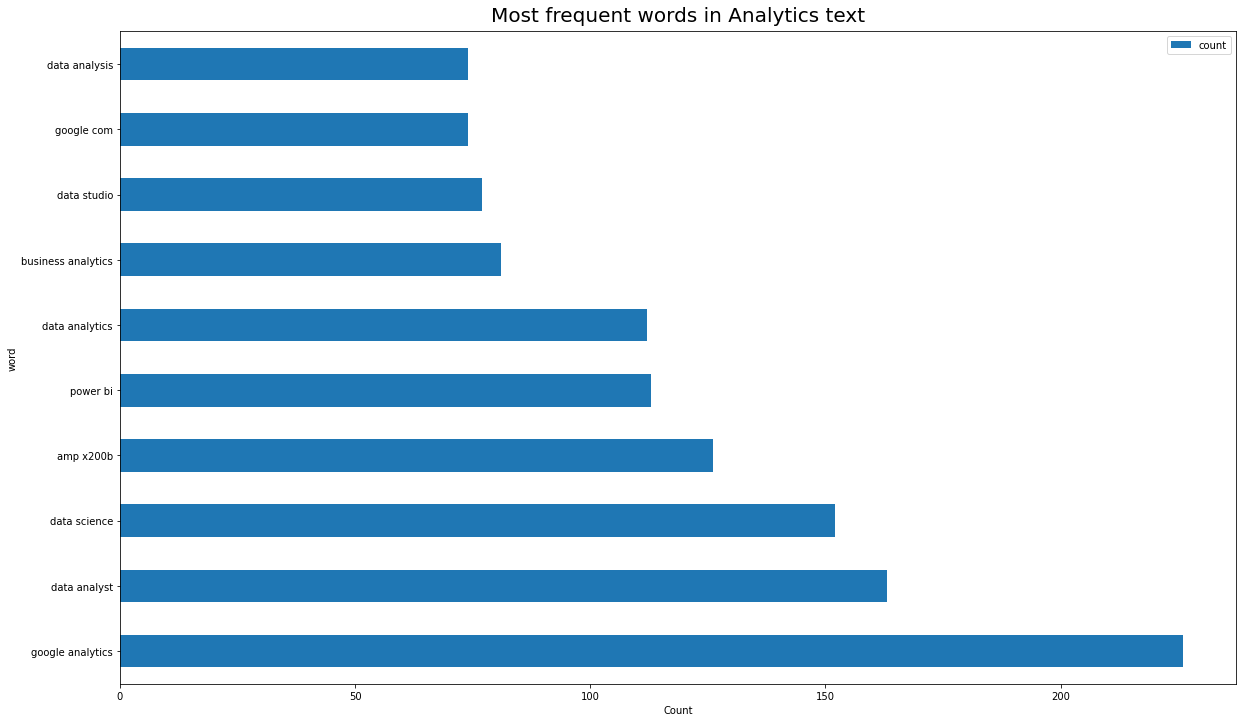

In [114]:
# plot bar graph of top word frequencies

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot()
top_an_3.plot(x="word",y='count', kind='barh', ax=ax)
ax.set_title("Most frequent words in Analytics text", fontsize=20, verticalalignment='bottom')
ax.set_xlabel("Count");

### Observations

+ This is much more informative the single words


+ Key themes and topics that are being discussed can clearly be seen to be forming
    + google analytics, data analyst, business anlaytics, data studio
    + data science also appears

---

### Save data

In [115]:
posts_df.to_csv('./data/post_eda/posts.csv', index = False)
comments_df.to_csv('./data/post_eda/comments.csv', index = False)

---

# 6.0 Insight

### Does my EDA allow me to answer the problem statement fully or to a certain extent?

+ There is still lots of unknowns and I would be unable to predict accurately. However I can answer my problem statement to a certain degree. I have found out the following:


#### Data Science

+ Average post lenght is 84

Key phrases and words
+ data science
+ machine learning
+ data engineering
+ dont know - Show enquisitive nature?


#### Anlaytics

+ Average post lenght is 79 which is 5 Words less

Key phrases and words
+ google analytics
+ data analyst
+ power bi
+ data studio


They also both make reference to each others names: data science and analytics
